In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import keras_tuner

from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

tf.config.experimental.enable_op_determinism(): guarantees that TensorFlow operations behave deterministically, i.e. the same inputs will always give the same outputs.

tf.random.set_seed(SEED): sets a global seed for TensorFlow. This affects the generation of random numbers in TensorFlow, which is crucial for initializing model weights and other random aspects of training.

In [2]:
SEED = 42
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(SEED)

In [3]:
# EarlyStop, patience means how it waits before deciding if stopping is needed
es = EarlyStopping(monitor='val_loss', patience=100, mode="min")

# when sweet spot / convergence seems to happen, start reducing learning rate
# in order to avoid overfitting. commonly used with EarlyStop
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=20, min_lr=0.0005)

In [4]:
# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

In [5]:
# combine all active callbacks into a list
# have only those you need, for example only ModelCheckpoint
callback_list = [es, reduce_lr]

In [6]:
# Loading already optimez dataset from Advanced data analytics course
df = pd.read_csv('cars_optimized.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)

In [7]:
df.head()

,Manufacturer,Prod. year,Leather interior,Mileage,Cylinders,Drive wheels,Wheel,price_levy_combined,Airbags_bins,Engine volume int,...,Pickup,Sedan,Universal,Diesel,Hybrid,LPG,Petrol,Automatic,Manual,Variator
0,LEXUS,2010,0,186005,6.0,4x4,0,14727,2,3.5,...,0,0,0,0,1,0,0,1,0,0
1,CHEVROLET,2011,1,192000,6.0,4x4,0,17639,2,3.0,...,0,0,0,0,0,0,1,0,0,0
2,HONDA,2006,1,200000,4.0,Front,1,8467,1,1.3,...,0,0,0,0,0,0,1,0,0,1
3,FORD,2011,0,168966,4.0,4x4,0,4469,0,2.5,...,0,0,0,0,1,0,0,1,0,0
4,HONDA,2014,0,91901,4.0,Front,0,12172,1,1.3,...,0,0,0,0,0,0,1,1,0,0


Besy R squared = 0.69 with original file from adv analytics course


Try #1: handle manufacturer by mapping to countries.

In [8]:
# Encode column and drop last feature to decrease column amount
variable = 'Drive wheels'
dummies = pd.get_dummies(df[variable]).astype(int)
df = pd.concat([df, dummies], axis=1).drop(columns=variable)

df.drop("Rear", axis=1, inplace=True)

In [9]:
# Updatred dictionary with countries of origin
# Most of them are joined to "Other", because of the imbalance 
car_manufacturers = {
    "Japan": ['LEXUS', 'HONDA', 'TOYOTA', 'NISSAN', 'SUBARU', 'MITSUBISHI', 'MAZDA', 'SUZUKI', 'ACURA', 'ISUZU', 'DAIHATSU', 'INFINITI', 'SCION'],
    "USA": ['CHEVROLET', 'FORD', 'JEEP', 'GMC', 'LINCOLN', 'DODGE', 'CHRYSLER', 'TESLA', 'BUICK', 'CADILLAC', 'HUMMER', 'MERCURY', 'PONTIAC', 'SATURN'],
    "South Korea": ['HYUNDAI', 'KIA', 'DAEWOO', 'SSANGYONG'],
    "Germany": ['MERCEDES-BENZ', 'OPEL', 'PORSCHE', 'BMW', 'VOLKSWAGEN', 'AUDI'],
    "Other": ['SKODA', 'სხვა', 'SEAT', 'VOLVO', 'SAAB','VAZ', 'GAZ', 'UAZ', 'MOSKVICH', 'ZAZ',
              'HAVAL', 'GREATWALL', 'FIAT', 'ALFA ROMEO', 'LANCIA', 'MASERATI', 'FERRARI', 'LAMBORGHINI',
              'LAND ROVER', 'MINI', 'JAGUAR', 'BENTLEY', 'ROLLS-ROYCE', 'ROVER', 'ASTON MARTIN', 'MG',
              'RENAULT', 'CITROEN', 'PEUGEOT']
}

# Now map a country to each manufacturer

# empty dictionary to store the mappings
manufacturer_to_country = {}

# Loop over each country and its list of manufacturers
for country, manufacturers in car_manufacturers.items():
    # For each manufacturer in the list, assign the country as the value
    for manufacturer in manufacturers:
        manufacturer_to_country[manufacturer] = country

# Create new column for country of origin and map it based on manufacturer
df['Country'] = df['Manufacturer'].map(manufacturer_to_country)



<Axes: xlabel='Country', ylabel='Count'>

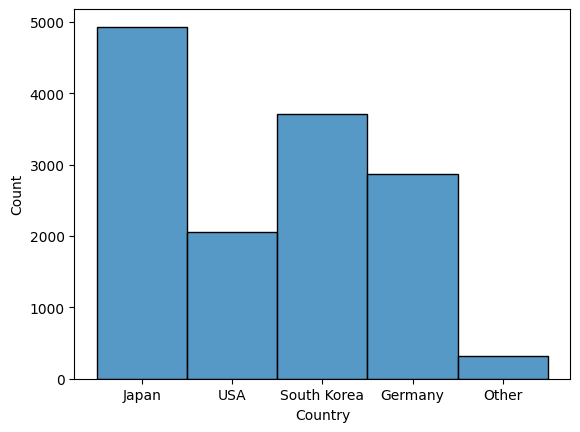

In [10]:
sns.histplot(data=df["Country"])

In [11]:
# encode categorical column into seperate features
variable = 'Country'
dummies = pd.get_dummies(df[variable]).astype(int)
df = pd.concat([df, dummies], axis=1).drop(columns=variable)

# Finally drop the manufacturer column, model, "other".
# Model column has almost 1600 distinct values and is basically just a name for the car, pretty similar to ID column
# I think there is no way to get any information out of model

df.drop(["Manufacturer", "Other"], axis=1, inplace=True)

In [12]:
# Cut even more outliers from poduction year
df = df[df["Prod. year"] > 1995]

In [13]:
# Cup lowest price to the 0.05 quantile
df = df[df["price_levy_combined"] > 1000]


In [14]:
# everything else except target variable
X = df.drop("price_levy_combined", axis=1)
# only target variable
y = df["price_levy_combined"]

# Split to 70% for training data and 30% for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Split the rest 30% for 15% validation and 15% training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [15]:
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.2)),
        layers.Dense(32, activation="relu"),
        layers.Dropout(rate=0.1),
        layers.Dense(24, activation="relu"),
        layers.Dense(1)
    ]
)

# optimal learning rate from keras tuner
optimal_lr = 0.005275753769624545

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer=keras.optimizers.Adam(), loss='mse')
# print out the summary of your model
model.summary()

/Users/kirillsobolev/Documents/GitHub/.venv/lib/python3.9/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,001 (19.54 KB)

 Trainable params: 4,941 (19.30 KB)

 Non-trainable params: 60 (240.00 B)

In [16]:
model.fit(x=X_train, y=y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/1000
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - loss: 501737536.0000 - val_loss: 1582027392.0000 - learning_rate: 0.0010
Epoch 2/1000
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 152681824.0000 - val_loss: 147592800.0000 - learning_rate: 0.0010
Epoch 3/1000
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 128886456.0000 - val_loss: 121072656.0000 - learning_rate: 0.0010
Epoch 4/1000
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 120437704.0000 - val_loss: 115268432.0000 - learning_rate: 0.0010
Epoch 5/1000
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 116607616.0000 - val_loss: 112303312.0000 - learning_rate: 0.0010
Epoch 6/1000
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 113296032.0000 - val_loss: 109970120.0000 - learning_rate: 0.0010
Epoch 7/1000
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 112653784.0000 - val_loss: 108295152.0000 - learning_rate: 0.0010
Epoch 8/1000
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 111154056.0000 - val_loss

<h2>Metrics</h2>

In [17]:
%matplotlib inline

<Axes: >

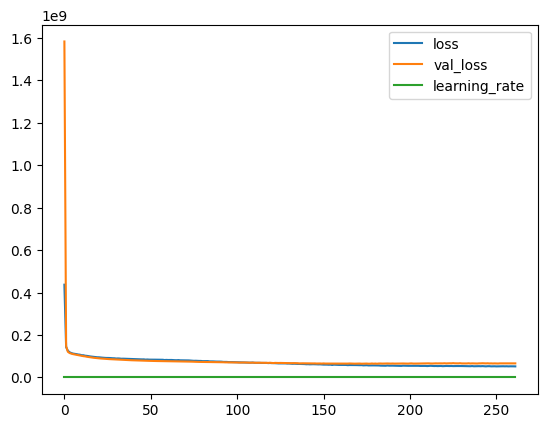

In [18]:
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

# other notes:
# if your validation loss is fluctuating a lot, the test data set
# might not be a good sample / representation of the whole dataset
# try to get more data or try shuffling the dataset for a better sample
# if your validation loss FLUCTUATES EXTREMELY: remember to create 
# the neural network again completely (Sequential etc.), otherwise you might fit your 
# model to your previous model version weights

In [19]:
# compare test error values to training error values
# the model is often good when these error values are similar
# even if you training metrics above didn't overlap
# you might still get very close values in evaluation => more important

# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
55395020.0

Train data evaluation:
50744172.0


In [20]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Test True Y,Model Predictions
0,18655,20306.416016
1,2220,13792.466797
2,4818,5579.197754
3,3340,7638.520996
4,12750,13210.757812
...,...,...
1984,23265,27533.058594
1985,8154,4265.051270
1986,15551,16545.142578
1987,19357,17736.041016


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

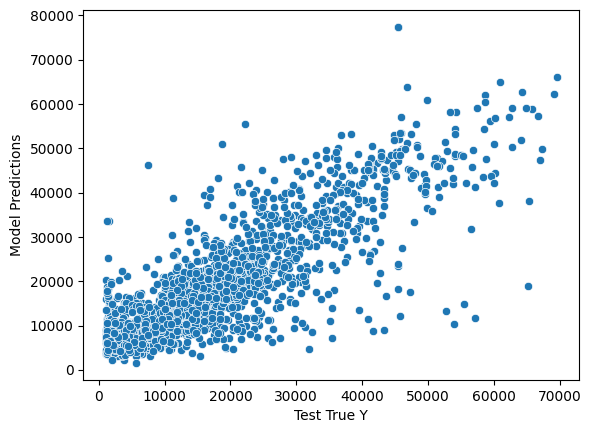

In [21]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [22]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
5069.66 $

MSE
55394863.17 $^2

RMSE:
7442.77 $

R-squared:
0.67

Explained variance score:
0.68


/var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_4682/130455776.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


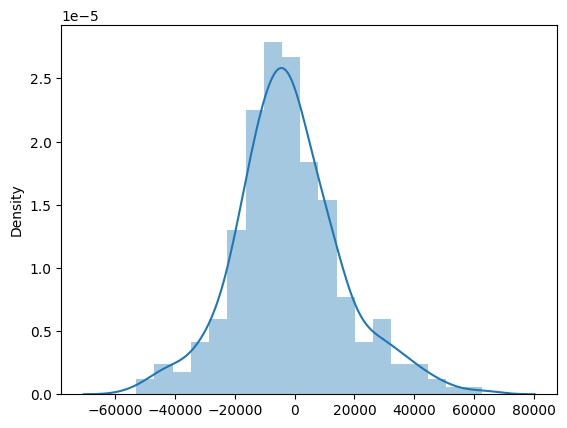

In [23]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()